# **PART I:** Sentiment analysis using LSTM [40 pts]

In this part, we perform a sentiment analysis using LSTM model. **NOTE:** The expected accuracy for this part is more than 75% for the final model.

## **Datasets**

Choose ONE dataset from the following options for sentiment analysis:

- [Amazon Product Reviews Dataset](https://www.kaggle.com/bittlingmayer/amazonreviews): reviews of various products sold on Amazon, labeled with sentiment.

- [Yelp Reviews Dataset](https://www.kaggle.com/yelp-dataset/yelp-dataset): reviews from the Yelp platform, labeled with sentiment.

- [Twitter Airline Sentiment Dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment): tweets about airline experiences, labeled with sentiment.

- [Stanford Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/): movie reviews classified as positive or negative.

- [Medical Dialogue Dataset](https://www.kaggle.com/datasets/xuehaihe/medical-dialogue-dataset): contains conversations (in English) between doctors and patients. It has 0.26 million dialogues.

- [News Headlines Dataset](https://www.kaggle.com/rmisra/news-category-dataset): news headlines labeled with sentiment, covering various news topics and categories.

#### QUESTION 0
Which dataset do you choose? Briefly justify your choice (e.g., relevance to your field of study or general interest).

<font color='green'>We Chose Amazon Product Reviews Dataset.The dataset consists of large-scale, detailed feedback from diverse users across numerous products, providing rich contextual information and sentiment labels that are valuable for training and evaluating sentiment analysis models.</font>



In [3]:
!unzip archive\ \(10\).zip

Archive:  archive (10).zip
  inflating: test.ft.txt.bz2         
  inflating: train.ft.txt.bz2        


In [4]:
import bz2
import shutil


input_file = 'train.ft.txt.bz2'
output_file = 'train.ft.txt'

with bz2.open(input_file, 'rb') as f_in, open(output_file, 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

In [5]:
input_file = 'test.ft.txt.bz2'
output_file = 'test.ft.txt'

with bz2.open(input_file, 'rb') as f_in, open(output_file, 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

## **TASK 1:** Data Exploration & Preprocessing

### **STEP 1:** Main Statistics

Read, preprocess, and print the main statistics about the dataset.

In [8]:
import pandas as pd
import re
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

def load_data(file_path):
    labels = []
    reviews = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            label, review = line.split(' ', 1)
            labels.append(label.strip())
            reviews.append(review.strip())
    return pd.DataFrame({'label': labels, 'review': reviews})

df_train = load_data('train.ft.txt').sample(frac=0.4, random_state=42)


df_train['label'] = df_train['label'].map({'__label__2': 1, '__label__1': 0})


def clean_text(text):
    text = re.sub(r'[^A-Za-z0-9\s]', '', text.lower())
    return text


df_train['cleaned_review'] = df_train['review'].apply(clean_text)

df_train['review_length'] = df_train['cleaned_review'].apply(lambda x: len(x.split()))

df_train = df_train.drop(['review'], axis=1)

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [9]:
df_test = load_data('test.ft.txt').sample(frac=0.4, random_state=42)

df_test['label'] = df_test['label'].map({'__label__2': 1, '__label__1': 0})

def clean_text(text):
    text = re.sub(r'[^A-Za-z0-9\s]', '', text.lower())
    return text

df_test['cleaned_review'] = df_test['review'].apply(clean_text)

df_test = df_test.drop(['review'], axis=1)

In [10]:
print(f"Total number of reviews: {len(df_train)}")
print(f"Number of positive reviews: {df_train['label'].sum()}")
print(f"Number of negative reviews: {len(df_train) - df_train['label'].sum()}")

Total number of reviews: 1440000
Number of positive reviews: 719400
Number of negative reviews: 720600


In [11]:
print(f"Total number of reviews: {len(df_test)}")
print(f"Number of positive reviews: {df_test['label'].sum()}")
print(f"Number of negative reviews: {len(df_test) - df_test['label'].sum()}")

Total number of reviews: 160000
Number of positive reviews: 79869
Number of negative reviews: 80131


In [12]:
df_train.head()

,label,cleaned_review,review_length
2079998,0,expensive junk this product consists of a piec...,101
1443106,0,toast too dark even on the lowest setting the ...,39
3463669,1,excellent imagerydumbed down story i enjoyed t...,70
2914699,0,are we pretending everyone is married the auth...,65
1603231,0,not worth your time might as well just use a k...,25


In [13]:
df_test.head()

,label,cleaned_review
23218,1,this is a great book i must preface this by sa...
20731,0,huge disappointment as a big time long term tr...
39555,1,wayne is tight but cant hang with turk this al...
147506,1,excellent i read this book when i was in eleme...
314215,0,not about anusara although this book is touted...


#### QUESTION 1
Provide brief details about the nature of your dataset:

- 1.1 What is it about?

- 1.2 What type of data are we encountering?

- 1.3 How many entries and variables does the dataset comprise?

<font color='green'>1.1 The dataset choose is a review dataset collected from the customers. The reviews are classified into two labels ; label1, label2. These two labels represent positive review and negative review. So the problem statment is to anlayze the sentiment of customers weather its positive or negative </font><br>
<font color='green'>1.2 The data that is being encountered is a textual data. This data is completely textual it consits of both uppercase and lowercase , also some of the special characters.   </font><br>
<font color='green'>1.3 So there are in all 3.6 million reviews in the dataset. The dataset has a label (one from the mentioned above) and has a review associated to that label.<br> NOTE: But for training purpose only 40% of data is used as there were limitations on the device that will be required for training this model and the scaliblity was an potential issue. </font>




### **STEP 2:** Data Visualization

Using any data visualization library (e.g. [matplotlib](https://matplotlib.org/stable/tutorials/introductory/usage.html#sphx-glr-tutorials-introductory-usage-py), [seaborn](https://seaborn.pydata.org/), [plotly](https://plotly.com/python/)), provide at least 3 visualization graphs related to your dataset.

Histogram : Distribution of the length of reviews

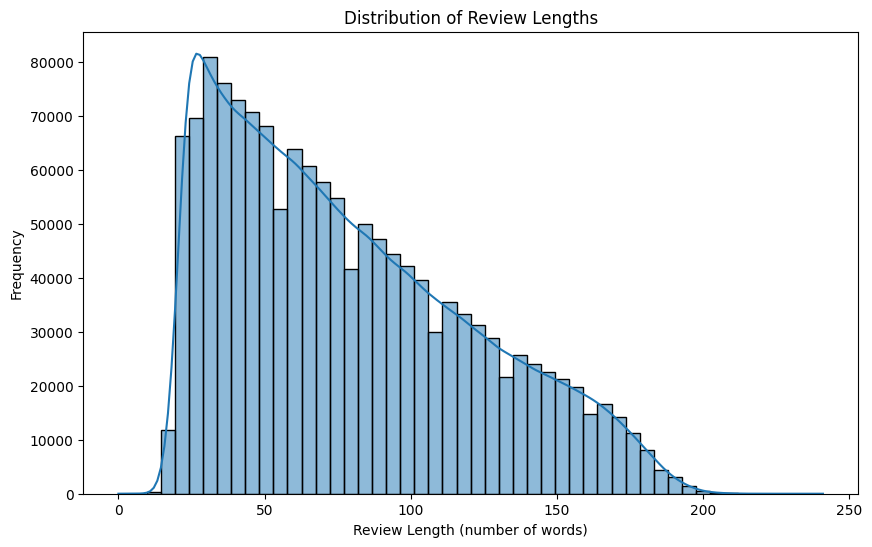

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


plt.figure(figsize=(10, 6))
sns.histplot(df_train['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (number of words)')
plt.ylabel('Frequency')
plt.show()


Bar Plot: Number of reviews for each label

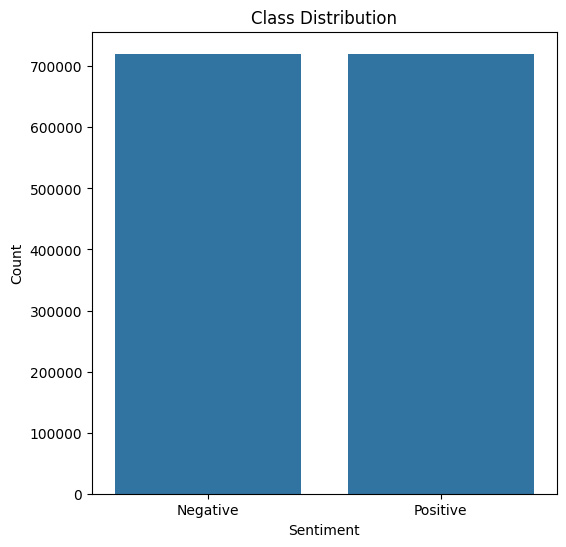

In [ ]:
plt.figure(figsize=(6, 6))
sns.countplot(x='label', data=df_train)
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

WordCloud: All the words present in the reviews

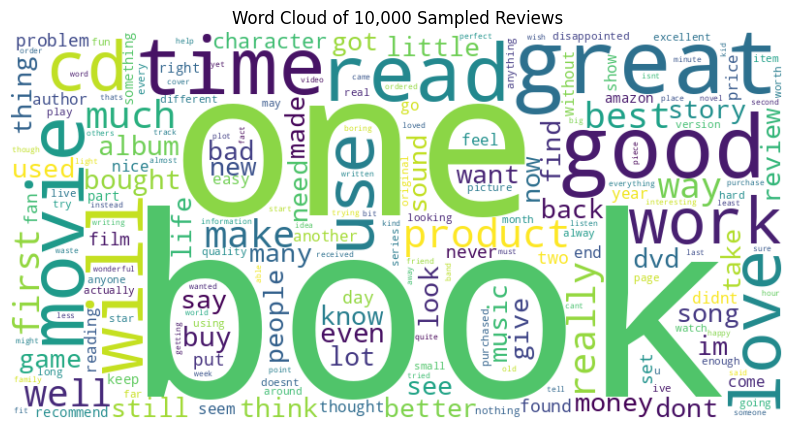

In [ ]:
sampled_df = df_train.sample(n=10000, random_state=42)
all_text = ' '.join(sampled_df['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of 10,000 Sampled Reviews')
plt.show()

### **STEP 3:** Prepare the Datasets

Example steps:

- Tokenize the text and converting it into numerical sequences

- Split it into training, validation and test sets

### Tokenizing, Padding the text and Splitting the training data into train and validation

In [ ]:
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(df_train['cleaned_review']), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

def text_pipeline(x):
    return vocab(tokenizer(x))

df_train['tokenized'] = df_train['cleaned_review'].apply(text_pipeline)
df_test['tokenized'] = df_test['cleaned_review'].apply(text_pipeline)

def pad_sequences(sequences, maxlen):
    padded_sequences = pad_sequence([torch.tensor(seq[:maxlen]) for seq in sequences], batch_first=True, padding_value=0)
    return padded_sequences

maxlen = 100
X_train = pad_sequences(df_train['tokenized'].tolist(), maxlen=maxlen)
y_train = torch.tensor(df_train['label'].values, dtype=torch.float32)

X_test = pad_sequences(df_test['tokenized'].tolist(), maxlen=maxlen)
y_test = torch.tensor(df_test['label'].values, dtype=torch.float32)

X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.11,random_state=42)

print(f"Training set size: {X_train.size(0)}")
print(f"Validation set size: {X_val.size(0)}")


Training set size: 1281600
Validation set size: 158400


### Loading the data using DataLoaders

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

## **TASK 2:** Build a LSTM Model

### **STEP 4:** Design an LSTM model

Build an LSTM model architecture that consists of at least three LSTM layers. You can use in-build LSTM layers, e.g. [torch.nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)


### Building the basic Lstm model with 3 layers

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, maxlen):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.maxlen = maxlen

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(lstm_out[:, -1, :])  # Use the last output of the LSTM
        return out

### Defining the required input parameters for the model

In [ ]:
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 128
output_dim = 1
num_layers = 3
maxlen = 100
batch_sizze = 512
num_epochs = 5
learning_rate = 0.001

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Initializing the model and defining the loss function along with optimizer

In [ ]:
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, maxlen)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Model Training and validation using train and val data. Testing the model on test data

In [ ]:
from tqdm import tqdm

def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, device):
    # Function to train the model
    def train(model, train_loader, criterion, optimizer, device):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        for inputs, labels in tqdm(train_loader, desc="Training", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            predicted = torch.round(torch.sigmoid(outputs))
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_preds / total_preds
        return train_loss, train_accuracy

    # Function to evaluate the model
    def evaluate(model, val_loader, criterion, device):
        model.eval()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Evaluating", unit="batch"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                predicted = torch.round(torch.sigmoid(outputs))
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)
        val_loss = running_loss / len(val_loader)
        val_accuracy = correct_preds / total_preds
        return val_loss, val_accuracy

    # Training and evaluation loop
    train_losses,train_accuracies = [],[]
    val_losses,val_accuracies = [],[]
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Evaluate on the test set
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    return test_loss, test_accuracy

# Example usage:
test_loss, test_accuracy = train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, device)


Evaluating: 100%|██████████| 310/310 [00:08<00:00, 35.41batch/s]


Epoch 1/5, Train Loss: 1508.8987, Train Accuracy: 0.6872, Validation Loss: 1464.5268, Validation Accuracy: 0.7206


Evaluating: 100%|██████████| 310/310 [00:10<00:00, 28.30batch/s]


Epoch 2/5, Train Loss: 1462.8248, Train Accuracy: 0.7719, Validation Loss: 1456.2554, Validation Accuracy: 0.7823


Evaluating: 100%|██████████| 310/310 [00:10<00:00, 28.62batch/s]


Epoch 3/5, Train Loss: 1454.0154, Train Accuracy: 0.7912, Validation Loss: 1454.4986, Validation Accuracy: 0.7551


Evaluating: 100%|██████████| 310/310 [00:10<00:00, 29.38batch/s]


Epoch 4/5, Train Loss: 1447.8791, Train Accuracy: 0.7990, Validation Loss: 1455.1629, Validation Accuracy: 0.7912


Evaluating: 100%|██████████| 310/310 [00:10<00:00, 29.06batch/s]


Epoch 5/5, Train Loss: 1442.5891, Train Accuracy: 0.8252, Validation Loss: 1457.0057, Validation Accuracy: 0.7750


Evaluating: 100%|██████████| 313/313 [00:08<00:00, 35.05batch/s]

Test Loss: 1458.7714, Test Accuracy: 0.7764


In [ ]:
import torch
torch.cuda.empty_cache()

### **STEP 5:** Experiment with Different Settings

1. Design multiple LSTM models with various setups and hyperparameters.

2. Train the LSTM model using **the training set** and use **the validation set** to monitor the performance.

3. Plot the training loss & accuracy over epochs for each model.

4. Plot the validation loss & accuracy over epochs for each model.

While you are welcome to experiment with various hyperparameters and setup, please include the three models that return the best result.


#### EXPERIMENT #1

### Adding the dropout layers to improve the model performance

In [ ]:
### YOUR CODE HERE ###
class LSTMDropoutClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, maxlen, dropout_prob):
        super(LSTMDropoutClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.maxlen = maxlen

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(lstm_out)
        return out


In [ ]:
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 128
output_dim = 1
num_layers = 3
maxlen = 100
batch_size = 512
num_epochs = 5
learning_rate = 0.001
dropout_prob = 0.5

In [ ]:
import torch.optim as optim
# Instantiate the model
model = LSTMDropoutClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, maxlen,dropout_prob)
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from tqdm import tqdm

def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, device):
    # Function to train the model
    def train(model, train_loader, criterion, optimizer, device):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        for inputs, labels in tqdm(train_loader, desc="Training", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            predicted = torch.round(torch.sigmoid(outputs))
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_preds / total_preds
        return train_loss, train_accuracy

    # Function to evaluate the model
    def evaluate(model, val_loader, criterion, device):
        model.eval()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Evaluating", unit="batch"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                predicted = torch.round(torch.sigmoid(outputs))
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)
        val_loss = running_loss / len(val_loader)
        val_accuracy = correct_preds / total_preds
        return val_loss, val_accuracy

    # Training and evaluation loop
    train_losses,train_accuracies = [],[]
    val_losses,val_accuracies = [],[]
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Evaluate on the test set
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    return test_loss, test_accuracy,train_losses,train_accuracies,val_losses,val_accuracies

# Example usage:
test_loss_dlstm, test_accuracy_dlstm,train_loss_li_dlstm,train_acc_li_dlstm,val_loss_li_dlstm,val_acc_li_dlstm = train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, device)


Evaluating: 100%|██████████| 310/310 [00:08<00:00, 35.18batch/s]


Epoch 1/5, Train Loss: 1558.2205, Train Accuracy: 0.7084, Validation Loss: 1514.9626, Validation Accuracy: 0.7788


Evaluating: 100%|██████████| 310/310 [00:08<00:00, 36.20batch/s]


Epoch 2/5, Train Loss: 1486.2422, Train Accuracy: 0.8817, Validation Loss: 1468.9258, Validation Accuracy: 0.9050


Evaluating: 100%|██████████| 310/310 [00:08<00:00, 36.04batch/s]


Epoch 3/5, Train Loss: 1468.8277, Train Accuracy: 0.9086, Validation Loss: 1463.0318, Validation Accuracy: 0.9043


Evaluating: 100%|██████████| 310/310 [00:10<00:00, 28.51batch/s]


Epoch 4/5, Train Loss: 1460.2609, Train Accuracy: 0.9163, Validation Loss: 1460.6082, Validation Accuracy: 0.9083


Evaluating: 100%|██████████| 310/310 [00:08<00:00, 36.33batch/s]


Epoch 5/5, Train Loss: 1453.6968, Train Accuracy: 0.9213, Validation Loss: 1461.2788, Validation Accuracy: 0.8844


Evaluating: 100%|██████████| 313/313 [00:09<00:00, 34.36batch/s]

Test Loss: 1462.8592, Test Accuracy: 0.8842


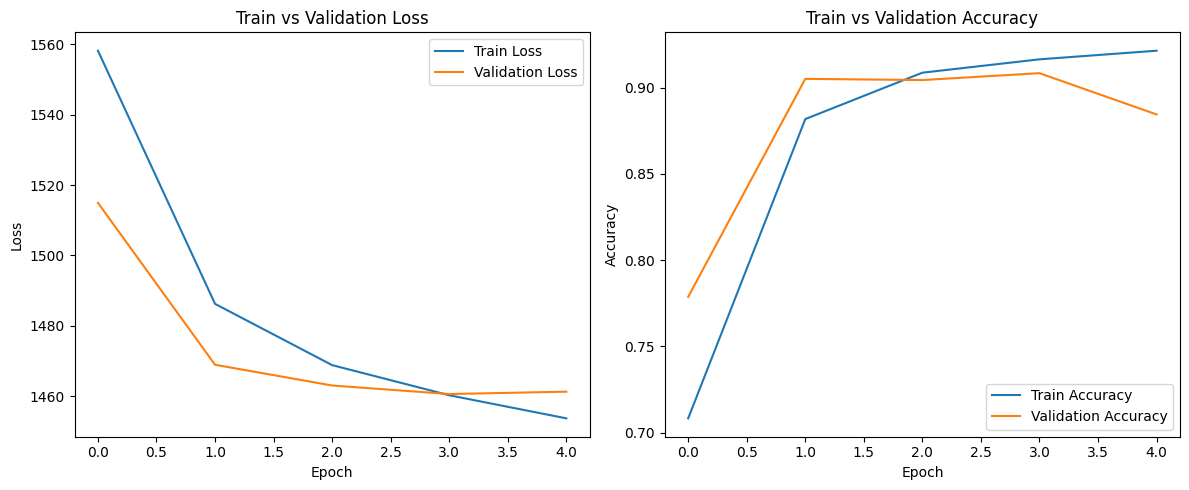

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_li_dlstm, label='Train Loss')
plt.plot(val_loss_li_dlstm, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_li_dlstm, label='Train Accuracy')
plt.plot(val_acc_li_dlstm, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model_save_path = 'ex1.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

#### EXPERIMENT #2

### Adding multiple Lstm Layers to make it more deep architecture

In [ ]:
### YOUR CODE HERE ###
class DeepLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, maxlen):
        super(DeepLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.maxlen = maxlen

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(lstm_out[:, -1, :])
        return out


In [ ]:
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 256
output_dim = 2
num_layers = 3
maxlen = 100
batch_size = 512
num_epochs = 5
learning_rate = 0.001

In [ ]:
# Instantiate the model
model_ex2 = DeepLSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, maxlen)
model = model_ex2.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def to_device(tensor, device):
    return tensor.to(device)

In [ ]:
from tqdm import tqdm

def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, device):
    # Function to train the model
    def train(model, train_loader, criterion, optimizer, device):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        for inputs, labels in tqdm(train_loader, desc="Training", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_preds / total_preds
        return train_loss, train_accuracy

    # Function to evaluate the model
    def evaluate(model, val_loader, criterion, device):
        model.eval()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Evaluating", unit="batch"):
                inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)
        val_loss = running_loss / len(val_loader)
        val_accuracy = correct_preds / total_preds
        return val_loss, val_accuracy

    # Training and evaluation loop
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Evaluate on the test set
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    return test_loss, test_accuracy, train_losses, train_accuracies, val_losses, val_accuracies
test_loss_ex2, test_accuracy_ex2,train_loss_li_ex2,train_acc_li_ex2,val_loss_li_ex2,val_acc_li_ex2 = train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, device)

Evaluating: 100%|██████████| 310/310 [00:17<00:00, 17.59batch/s]


Epoch 1/5, Train Loss: 0.4160, Train Accuracy: 0.7879, Validation Loss: 0.2267, Validation Accuracy: 0.9076


Evaluating: 100%|██████████| 310/310 [00:17<00:00, 17.86batch/s]


Epoch 2/5, Train Loss: 0.1905, Train Accuracy: 0.9254, Validation Loss: 0.1802, Validation Accuracy: 0.9296


Evaluating: 100%|██████████| 310/310 [00:17<00:00, 17.59batch/s]


Epoch 3/5, Train Loss: 0.1519, Train Accuracy: 0.9429, Validation Loss: 0.1769, Validation Accuracy: 0.9312


Evaluating: 100%|██████████| 310/310 [00:15<00:00, 19.74batch/s]


Epoch 4/5, Train Loss: 0.1257, Train Accuracy: 0.9543, Validation Loss: 0.1628, Validation Accuracy: 0.9386


Evaluating: 100%|██████████| 310/310 [00:15<00:00, 19.75batch/s]


Epoch 5/5, Train Loss: 0.1038, Train Accuracy: 0.9635, Validation Loss: 0.1668, Validation Accuracy: 0.9381


Evaluating: 100%|██████████| 313/313 [00:15<00:00, 19.81batch/s]

Test Loss: 0.1674, Test Accuracy: 0.9389


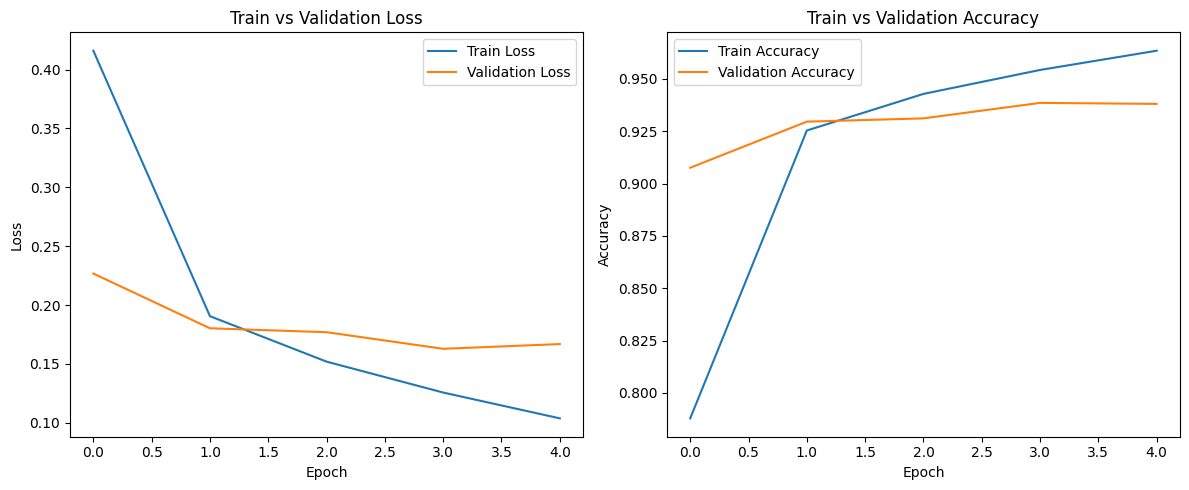

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_li_ex2, label='Train Loss')
plt.plot(val_loss_li_ex2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_li_ex2, label='Train Accuracy')
plt.plot(val_acc_li_ex2, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model_save_path = 'ex2.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

In [ ]:
files.download(model_save_path)

#### EXPERIMENT #3

### Adding two fully connected layers and increasing the number of lstm layers

In [ ]:
### YOUR CODE HERE ###
class MultiFCLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, maxlen):
        super(MultiFCLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)
        self.relu = nn.ReLU()
        self.maxlen = maxlen

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        fc1_out = self.relu(self.fc1(lstm_out[:, -1, :]))
        out = self.fc2(fc1_out)
        return out

In [ ]:
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 256
output_dim = 2
num_layers = 3
maxlen = 100
batch_size = 512
num_epochs = 5
num_classes = 2
learning_rate = 0.001

In [ ]:
# Instantiate the model
model_ex3 = MultiFCLSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_classes, num_layers, maxlen)
model = model_ex3.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from tqdm import tqdm

def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, device):
    # Function to train the model
    def train(model, train_loader, criterion, optimizer, device):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        for inputs, labels in tqdm(train_loader, desc="Training", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_preds / total_preds
        return train_loss, train_accuracy

    # Function to evaluate the model
    def evaluate(model, val_loader, criterion, device):
        model.eval()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Evaluating", unit="batch"):
                inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)
        val_loss = running_loss / len(val_loader)
        val_accuracy = correct_preds / total_preds
        return val_loss, val_accuracy

    # Training and evaluation loop
    train_losses,train_accuracies = [],[]
    val_losses,val_accuracies = [],[]
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Evaluate on the test set
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    return test_loss, test_accuracy,train_losses,train_accuracies,val_losses,val_accuracies

# Example usage:
test_loss_ex3, test_accuracy_ex3,train_loss_li_ex3,train_acc_li_ex3,val_loss_li_ex3,val_acc_li_ex3 = train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, device)

Evaluating: 100%|██████████| 310/310 [00:16<00:00, 18.71batch/s]


Epoch 1/5, Train Loss: 0.4873, Train Accuracy: 0.6977, Validation Loss: 0.1821, Validation Accuracy: 0.9283


Evaluating: 100%|██████████| 310/310 [00:16<00:00, 18.74batch/s]


Epoch 2/5, Train Loss: 0.1584, Train Accuracy: 0.9396, Validation Loss: 0.1523, Validation Accuracy: 0.9423


Evaluating: 100%|██████████| 310/310 [00:16<00:00, 18.58batch/s]


Epoch 3/5, Train Loss: 0.1238, Train Accuracy: 0.9548, Validation Loss: 0.1504, Validation Accuracy: 0.9440


Evaluating: 100%|██████████| 310/310 [00:16<00:00, 18.73batch/s]


Epoch 4/5, Train Loss: 0.0955, Train Accuracy: 0.9668, Validation Loss: 0.1616, Validation Accuracy: 0.9424


Evaluating: 100%|██████████| 310/310 [00:16<00:00, 18.37batch/s]


Epoch 5/5, Train Loss: 0.0685, Train Accuracy: 0.9777, Validation Loss: 0.1842, Validation Accuracy: 0.9377


Evaluating: 100%|██████████| 313/313 [00:16<00:00, 18.54batch/s]

Test Loss: 0.1859, Test Accuracy: 0.9373


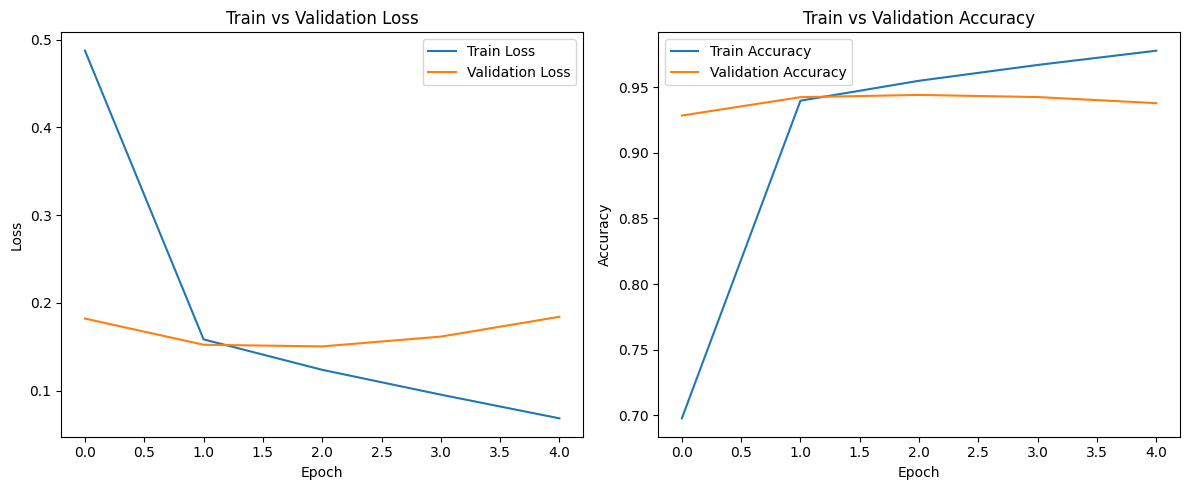

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_li_ex3, label='Train Loss')
plt.plot(val_loss_li_ex3, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_li_ex3, label='Train Accuracy')
plt.plot(val_acc_li_ex3, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model_save_path = 'ex3.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

In [ ]:
files.download(model_save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **STEP 6:** Evaluate the Models

1. Compare the performance of the three models based on the metrics obtained from the validation set.<br>
<font color='green'>1. The validation accuracies for each of the model is calculated while training itself. For the first model it is around 88%, for seconf model it is around 93.81% and even for the third model it is around 93.77%.<br>2.But when compared with the train accuracies the difference between train and validation accuracy is the lowest for second expiremental model.<br>3. This indicates less overfitting and so the best model is second expiremental model which is a deep architecture with multiple lstm layers</font>

2. Save the weights of the final model that returns best results.<br>
<font color='green'>The best model is saved as ex2.pth</font>

3. Evaluate the best model using **the test set**.

4. Report the loss & accuracy of the best model on the test set.

5. Generate a confusion matrix using the predictions on the test set.

#### Evaluating the model on test set and calculating test loss and test accuracy and generating confusion matrix

In [ ]:
### YOUR CODE HERE ###
from sklearn.metrics import confusion_matrix
import numpy as np

def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device, dtype=torch.long)
            outputs = model(texts)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            predictions.extend(predicted.cpu().numpy())
            ground_truth.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct / len(test_loader.dataset)

    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # Generate confusion matrix
    cm = confusion_matrix(ground_truth, predictions)
    return avg_test_loss, test_accuracy, cm

# Assuming `test_loader` is your DataLoader for the test dataset
test_loss, test_accuracy, confusion_mat = test_model(model, test_loader, criterion, device)

print('Confusion Matrix:')
print(confusion_mat)

Test Loss: 0.1674, Test Accuracy: 0.9389
Confusion Matrix:
[[75587  4544]
 [ 5234 74635]]


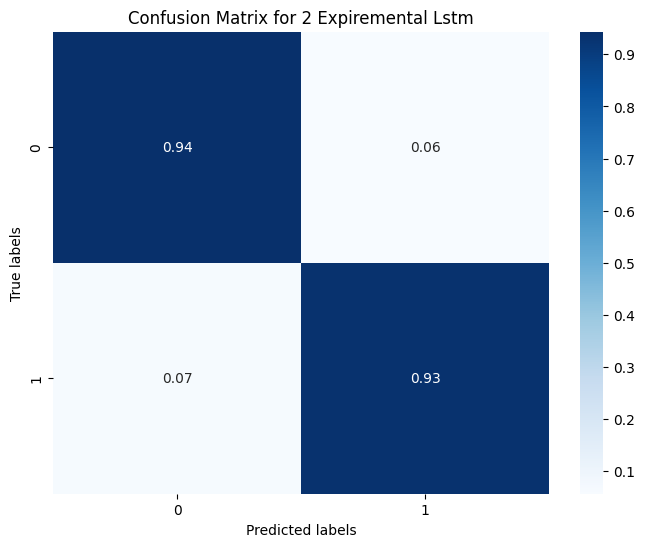

In [ ]:
import seaborn as sns

# Calculate normalized confusion matrix
cm_normalized = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]

# Plotting confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for 2 Expiremental Lstm')
plt.show()

#### QUESTION 2
Provide the details related to your LSTM architecture that returns the best result.

<font color='green'>1.The architecture includes an embedding layer to convert input tokens into dense vectors of a specified dimension.<br>2.This is followed by an LSTM layer with a specified number of hidden units and multiple layers, which processes the embedded sequences.<br>3.The LSTM's output at the last time step is passed through a fully connected layer to generate the final output of the network, which can be used for classification.
<br>4.To prevent overfitting, dropout is applied both within the LSTM layers and after the LSTM outputs. The use of dropout, specified by dropout_prob, helps in regularizing the model.</font>



#### QUESTION 3
Analyze the graphs and results obtained during the training, validation, and test steps.

<font color='green'>Considering the first Expiremental model:<br>1. Training loss against Validation loss : The training loss starts off at around 0.35 and then decreases over time to around 0.10. This indicates that the model is being trained properly.The validation loss also decreases over time, from about 0.35 to 0.20. This indicates that the model is being generalized well.
<br>2.Training accuracy against Validation accuracy : The training accuracy starts off low and then increases over time, which suggests that the model is learning. The validation accuracy also increases over time, but it is always lower than the training accuracy. <br> 3.The test loss is calculated as 0.1674 and Test Accuracy to be 0.9389 <br> 4. Confusion Matrix : The high values are concentrated on the leftmost column, which corresponds to the model predicting class "1". This means the model is biased towards predicting class "1" and missing instances of class "0".</font>


## **TASK 3:** Build an Improved LSTM Model

### **STEP 7:** Design an Improved LSTM Model

Use any other version of LSTM model architecture to improve the results, e.g., Gated Recurrent Unit (GRU), Bidirectional LSTM, Stacked LSTM.

### Model with embeddings, bidirectional LSTM layers, and fully connected output layer.

In [ ]:
### YOUR CODE HERE ###
import torch.nn as nn

class BidirectionalLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes, num_layers=3):
        super(BidirectionalLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        h_0 = torch.zeros(num_layers * 2, x.size(0), hidden_size).to(device)  # *2 for bidirectional
        c_0 = torch.zeros(num_layers * 2, x.size(0), hidden_size).to(device)

        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
vocab_size = len(vocab) + 1
embed_size = 128
hidden_size = 128
num_classes = 2
num_layers = 3
num_epochs = 5
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### EXPERIMENT #1

In [ ]:
### YOUR CODE HERE ###
import torch
from tqdm.notebook import tqdm
from torch import nn

def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for texts, labels in tqdm(train_loader):
            texts, labels = texts.to(device), labels.to(device, dtype=torch.long)

            # Forward pass
            outputs = model(texts)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device, dtype=torch.long)
                outputs = model(texts)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Example usage:
model = BidirectionalLSTMModel(vocab_size, embed_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Train and evaluate the model
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, device=device)

  0%|          | 0/2504 [00:00<?, ?it/s]

Epoch [1/5], Train Loss: 0.2593, Validation Loss: 0.1655, Training Accuracy: 0.8807, Validation Accuracy: 0.9363


  0%|          | 0/2504 [00:00<?, ?it/s]

Epoch [2/5], Train Loss: 0.1450, Validation Loss: 0.1519, Training Accuracy: 0.9454, Validation Accuracy: 0.9424


  0%|          | 0/2504 [00:00<?, ?it/s]

Epoch [3/5], Train Loss: 0.1163, Validation Loss: 0.1487, Training Accuracy: 0.9581, Validation Accuracy: 0.9448


  0%|          | 0/2504 [00:00<?, ?it/s]

Epoch [4/5], Train Loss: 0.0908, Validation Loss: 0.1626, Training Accuracy: 0.9687, Validation Accuracy: 0.9409


  0%|          | 0/2504 [00:00<?, ?it/s]

Epoch [5/5], Train Loss: 0.0676, Validation Loss: 0.1880, Training Accuracy: 0.9779, Validation Accuracy: 0.9396


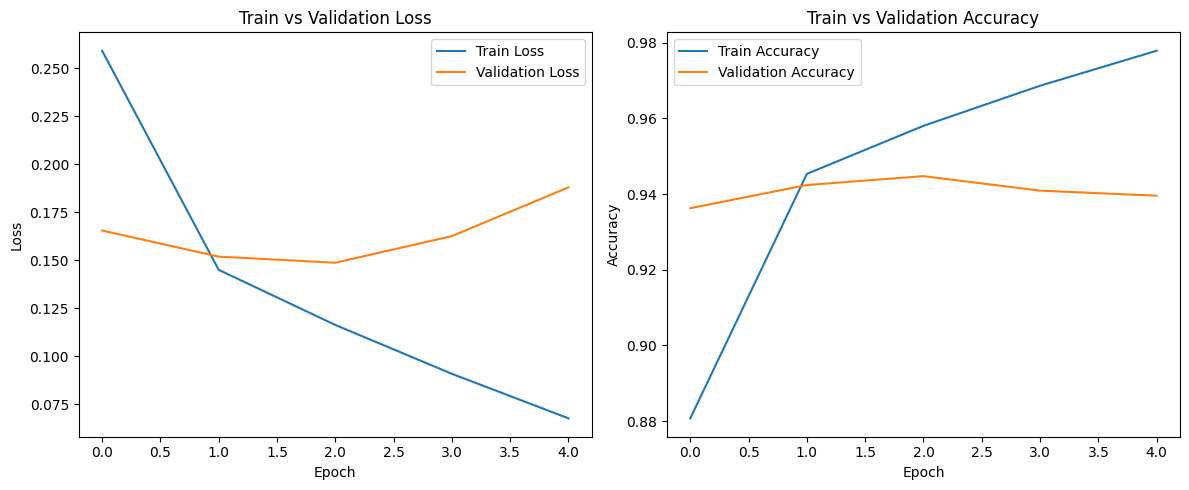

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model_save_path = 'bi_ex1.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

#### EXPERIMENT #2

### Bidirectional LSTM with 4 LSTM layers and explicit initialization of LSTM states

In [ ]:
### YOUR CODE HERE ###
import torch.nn as nn

class BidirectionalLSTMModel1(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes, num_layers=4):
        super(BidirectionalLSTMModel1, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.num_layers = num_layers
        self.hidden_size = hidden_size

    def forward(self, x):
        x = self.embedding(x)
        h_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)  # *2 for bidirectional
        c_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out


vocab_size = len(vocab) + 1
embed_size = 128
hidden_size = 128
num_classes = 2
num_layers = 4
num_epochs = 2
learning_rate = 0.001

model1 = BidirectionalLSTMModel1(vocab_size, embed_size, hidden_size, num_classes).to(device)

# Train and evaluate the model
train_losses2, val_losses2, train_accuracies2, val_accuracies2 = train_and_evaluate(model1, train_loader, val_loader, criterion, optimizer, num_epochs=5, device=device)



  0%|          | 0/2504 [00:00<?, ?it/s]

Epoch [1/5], Train Loss: 0.6932, Validation Loss: 0.6932, Training Accuracy: 0.4997, Validation Accuracy: 0.4990


  0%|          | 0/2504 [00:00<?, ?it/s]

Epoch [2/5], Train Loss: 0.6932, Validation Loss: 0.6932, Training Accuracy: 0.4997, Validation Accuracy: 0.4990


  0%|          | 0/2504 [00:00<?, ?it/s]

Epoch [3/5], Train Loss: 0.6932, Validation Loss: 0.6932, Training Accuracy: 0.4997, Validation Accuracy: 0.4990


  0%|          | 0/2504 [00:00<?, ?it/s]

Epoch [4/5], Train Loss: 0.6932, Validation Loss: 0.6932, Training Accuracy: 0.4997, Validation Accuracy: 0.4990


  0%|          | 0/2504 [00:00<?, ?it/s]

Epoch [5/5], Train Loss: 0.6932, Validation Loss: 0.6932, Training Accuracy: 0.4997, Validation Accuracy: 0.4990


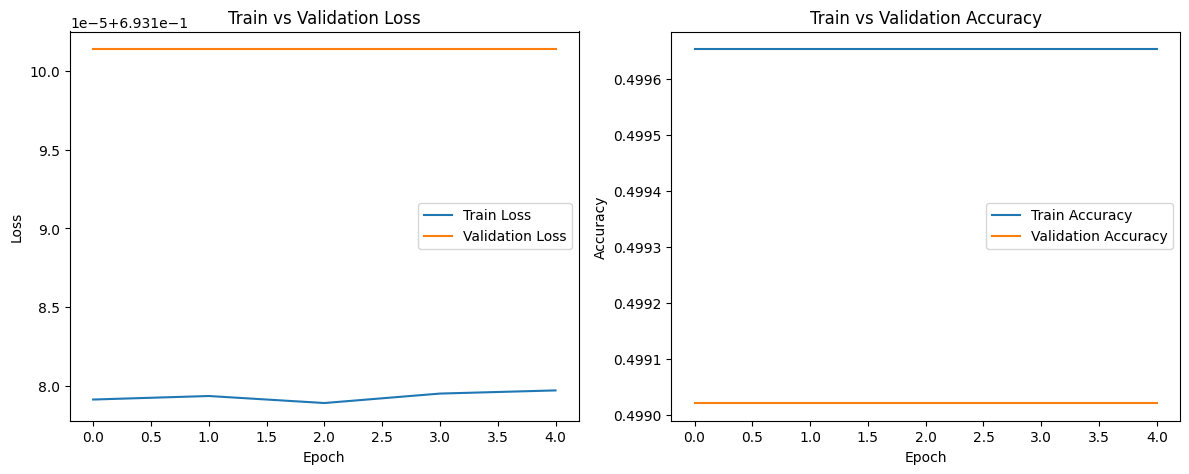

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses2, label='Train Loss')
plt.plot(val_losses2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies2, label='Train Accuracy')
plt.plot(val_accuracies2, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#### EXPERIMENT #3

### Reducing the learniong Rate

In [ ]:
class BidirectionalLSTMModel3(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes, num_layers=3):
        super(BidirectionalLSTMModel3, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        # Initialize the hidden state and the cell state
        h_0 = torch.zeros(self.lstm.num_layers * 2, x.size(0), self.lstm.hidden_size).to(x.device)  # num_layers * num_directions
        c_0 = torch.zeros(self.lstm.num_layers * 2, x.size(0), self.lstm.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h_0, c_0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
### YOUR CODE HERE ###
hidden_size = 128

optimizer1 = torch.optim.Adam(model.parameters(), lr=0.01)

model2 = BidirectionalLSTMModel3(vocab_size, embed_size, hidden_size, num_classes).to(device)

# Train and evaluate the model
train_losses3, val_losses3, train_accuracies3, val_accuracies3 = train_and_evaluate(model2, train_loader, val_loader, criterion, optimizer1, num_epochs=5, device=device)


  0%|          | 0/2504 [00:00<?, ?it/s]

Epoch [1/5], Train Loss: 0.6934, Validation Loss: 0.6935, Training Accuracy: 0.4997, Validation Accuracy: 0.4990


  0%|          | 0/2504 [00:00<?, ?it/s]

Epoch [2/5], Train Loss: 0.6934, Validation Loss: 0.6935, Training Accuracy: 0.4997, Validation Accuracy: 0.4990


  0%|          | 0/2504 [00:00<?, ?it/s]

Epoch [3/5], Train Loss: 0.6934, Validation Loss: 0.6935, Training Accuracy: 0.4997, Validation Accuracy: 0.4990


  0%|          | 0/2504 [00:00<?, ?it/s]

Epoch [4/5], Train Loss: 0.6934, Validation Loss: 0.6935, Training Accuracy: 0.4997, Validation Accuracy: 0.4990


  0%|          | 0/2504 [00:00<?, ?it/s]

Epoch [5/5], Train Loss: 0.6934, Validation Loss: 0.6935, Training Accuracy: 0.4997, Validation Accuracy: 0.4990


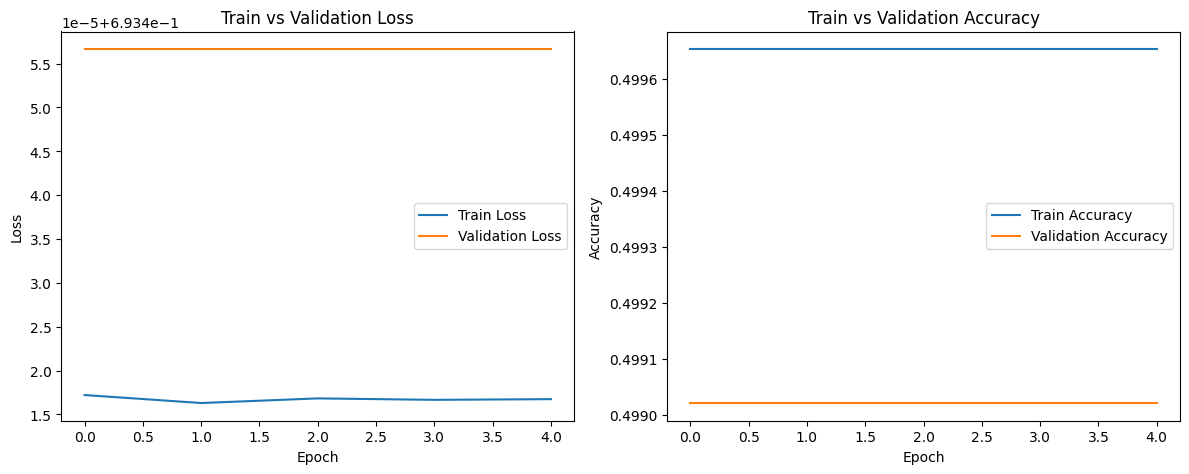

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses3, label='Train Loss')
plt.plot(val_losses3, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies3, label='Train Accuracy')
plt.plot(val_accuracies3, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### **STEP 9:** Evaluate the Improved Models

1. Compare the performance of the three improved models based on the metrics obtained from the validation set.<br><font color='green'>1. The validation accuracies for each of the model is calculated while training itself. For the first model it is around 93%, for second model it is around 49% and even for the third model it is around 49%%.<br>2.For the second and third model the validation accuracies are pleatued indicating there in no change in the models performance on the unseen data. The model is being stagnent in its performance<br>3.Thus the basic bidirectinal model with embedding layers, bidirectinal layers is the best out of three expirements</font>

2. Save the weights of the final improved model that returns best results.<br><font color='green'> The best model is saved as bi_ex1.pth</font>

3. Evaluate the best improved model using **the test set**.

4. Report the loss & accuracy of the best improved model on the test set.

5. Generate a confusion matrix using the predictions on the test set.

In [ ]:
### YOUR CODE HERE ###
from sklearn.metrics import confusion_matrix
import numpy as np

def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device, dtype=torch.long)
            outputs = model(texts)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            predictions.extend(predicted.cpu().numpy())
            ground_truth.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct / len(test_loader.dataset)

    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # Generate confusion matrix
    cm = confusion_matrix(ground_truth, predictions)
    return avg_test_loss, test_accuracy, cm

# Assuming `test_loader` is your DataLoader for the test dataset
test_loss, test_accuracy, confusion_mat = test_model(model, test_loader, criterion, device)

print('Confusion Matrix:')
print(confusion_mat)

Test Loss: 0.1898, Test Accuracy: 0.9387
Confusion Matrix:
[[75833  4298]
 [ 5512 74357]]


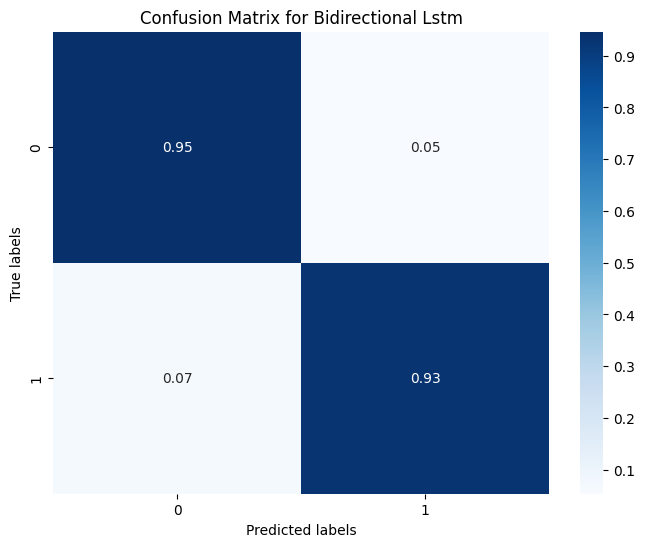

In [ ]:
import seaborn as sns

# Calculate normalized confusion matrix
cm_normalized = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]

# Plotting confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Bidirectional Lstm')
plt.show()


#### QUESTION 4
Provide the details related to your improved LSTM architecture that returns the best accuracy.

<font color='green'>1.The architecture starts with an embedding layer to convert input tokens into dense vectors .<br>2.It utilizes a bidirectional LSTM with multiple layers and hidden units to process sequences bidirectionally, capturing long-range dependencies.<br> 3.Dropout is applied within LSTM layers and after LSTM outputs to prevent overfitting.<br>4.The LSTM's last time step output is passed through a fully connected layer for classification into num_classes.
</font>


#### QUESTION 5
Analyze the graphs and results obatined during the training, validation, and test steps.

<font color='green'>Considering the first Expiremental model:<br>1. Training loss against Validation loss : The training loss starts off high and then decreases over time, which indicates that the model is learning. The validation loss also decreases over time, but it is always higher than the training loss. This is because the validation loss is measured on unseen data<br>2.Training accuracy against Validation accuracy : The training accuracy starts off low and then increases over time, which indicates that the model is learning. The validation accuracy also increases over time, but it is always lower than the training accuracy <br> 3.The test loss is calculated as 0.1893 and Test Accuracy to be 0.9387 <br> 4. Confusion Matrix : model is predicting the class label "1" far more often than it should be. Ideally, the diagonal entries of the confusion matrix would have high values, which would indicate that the model is correctly predicting the class labels. Here, the high values are concentrated on the leftmost column, which corresponds to the model predicting class "1". This means the model is biased towards predicting class "1" and missing instances of class "0".<br>5. Also we could say that there could be some data bias or this model is not correct for this data</font>


#### QUESTION 6
Compare the performance of the LSTM model and the improved LSTM model applied to the same dataset.

<font color='green'>The test accuracy for LSTM model is 93% and for improved LSTM is around 93%.<br>2.Although the improved model has more LSTM layers, allowing it to capture more complex patterns and dependencies in the data the basic LSTM model with multiple lstm layer also has nearly same performance.<br>3.From the observed results and analyzing the metrics it can be concluded that this data doesnot have a complex pattern that will require a bidirectional LSTM.<br>4.The training and computational cost for both the architectures is same. So it can be concluded that the basic LSTM with multiple layers is the best or suitable model for this data</font>



#### QUESTION 7
Discuss the strengths and limitations of using recurrent neural models for sentiment analysis.

<font color='green'>STRENGTHS<br> 1. RNNs are good  at capturing dependencies and relationships between words in a sequence.And this is  crucial for understanding sentiment in text and so for sentiment Analysis. <br>2.RNNs can handle variable-length sequences and it is good for sentiment analysis as the length of input varies and is not fixed.<br>LIMITATIONS<br>1.Despite their ability to handle variable-length inputs, RNNs can still struggle with very long sequences and in Sentiment Analysis one doenot have a command on the input size.<br>2.RNNs, especially more complex variants like LSTMs and GRUs, can be computationally expensive to train compared to simpler models.</font>


## **References**

Include all the references that have been used to complete the assignment.

<font color='green'>https://discuss.pytorch.org/t/how-to-make-an-lstm-bidirectional/142928<br>https://discuss.pytorch.org/t/implementing-an-lstm-from-scratch-leads-to-different-results/58458<br>https://www.geeksforgeeks.org/how-to-use-pytorch-for-sentiment-analysis-on-textual-data/</font>

